In [1]:
# load packages:
# package requirement: tensorflow-gpu 1.15.2, keras 2.3.1 munkres
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as pathces
import sys

from mmDUFS import JointModel
from mmDUFS import DiffModel
from mmDUFS import DataSet

from baselines import *

from sklearn.metrics import f1_score
from scipy import stats

Using TensorFlow backend.


In [2]:
!nvidia-smi

Thu Jun  1 15:43:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 29%   29C    P8    15W / 250W |    817MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 29%   

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [7]:
# load the data
rescaled_data = np.load("./datasets/rescaled_mnist.npz",allow_pickle=True)
X_z=rescaled_data['X']
Y_z=rescaled_data['Y']
gt_feat_joint_X=rescaled_data['gt_feat_joint_X']
gt_feat_joint_Y=rescaled_data['gt_feat_joint_Y']
gt_feat_diff_X=rescaled_data['gt_feat_diff_X']
gt_feat_diff_Y=rescaled_data['gt_feat_diff_Y']

In [8]:
# run baselines
baseline_f1 = fs_eval(X = X_z,
        Y =  Y_z,
        label_true_X = gt_feat_joint_X.reshape(-1),
        label_true_Y = gt_feat_joint_Y.reshape(-1),
        baselines = ["concat","sum","prod"],
        nx=np.sum(gt_feat_joint_X == 1),
        ny=np.sum(gt_feat_joint_Y == 1), 
        knn=2,fac=5, laplacian="normalized")
   

In [9]:
baseline_f1

{'concat': {'X': 0.35465116279069764, 'Y': 0.48258706467661694},
 'sum': {'X': 0.5523255813953488, 'Y': 0.6169154228855721},
 'prod': {'X': 0.5523255813953488, 'Y': 0.6169154228855721}}

In [8]:
# run mmDUFS with the shared op

In [10]:
shared_mmdufs_params = {
    "lam1":1e-1, # lambda x
    "lam2":1e-1, # lambda y
    "batch_size":X_z.shape[0], # full batch
    "const2":1e2
}
shared_mmdfus_learning_rate = 2
display_step = 1000
epochs = 10000

In [11]:
dataset = DataSet(**{'_data1':X_z,
                         '_data2':Y_z}
                         )

shared_mmdufs_params["input_dim1"] = X_z.shape[1]
shared_mmdufs_params["input_dim2"] = Y_z.shape[1]
    
model = JointModel(**shared_mmdufs_params) 
    
shared_result= model.train(dataset,
                            learning_rate=shared_mmdfus_learning_rate,
                        feature_label1 = gt_feat_joint_X.reshape(-1), 
                        feature_label2 = gt_feat_joint_Y.reshape(-1),
                        display_step=display_step, 
                        num_epoch=epochs) #30000







The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



num_samples : 500
Epoch: 1000 loss= 0.060361095 score1= -0.051728457 score2= -0.050663147 reg1= 0.813704908 reg2= 0.813821971 f1 - Mod1 =  0.3519 f1 - Mod2 =  0.3906
Epoch: 2000 loss= 0.056240521 score1= -0.050051618 score2= -0.051212557 reg1= 0.787490427 reg2= 0.787556529 f1 - Mod1 =  0.4348 f1 - Mod2 =  0.4291
Epoch: 3000 loss= 0.048034884 score1= -0.052730009 score2= -0.051815778 reg1= 0.762837529 reg2= 0.762969196 f1 - Mod1 =  0.5397 f1 - Mod2 =  0.5087
Epoch: 4000 loss= 0.045469224 score1= -0.050895777 score2= -0.0515126

In [12]:
selected_pixels_1 = np.zeros(28*56)
selected_pixels_1[np.argsort(model.get_raw_alpha1())[::-1][:np.sum(gt_feat_joint_X == 1)]] = 1
selected_pixels_1 = selected_pixels_1.reshape(28,56)

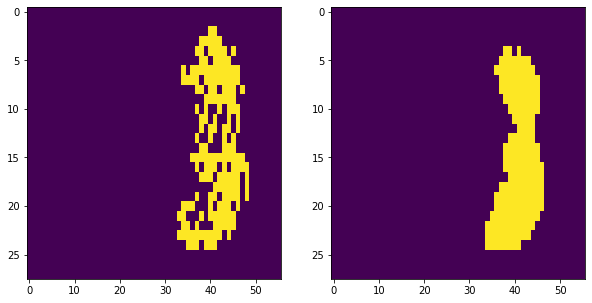

In [13]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(selected_pixels_1,aspect="auto")
axs[1].imshow(gt_feat_joint_X.reshape(28,56),aspect="auto")

plt.show()

In [14]:
f1_score(gt_feat_joint_X.reshape(-1).astype(int),selected_pixels_1.reshape(-1).astype(int))

0.7151162790697675

In [15]:
selected_pixels_2 = np.zeros(28*56)
selected_pixels_2[np.argsort(model.get_raw_alpha2())[::-1][:np.sum(gt_feat_joint_Y == 1)]] = 1
selected_pixels_2 = selected_pixels_2.reshape(28,56)

In [16]:
f1_score(gt_feat_joint_Y.reshape(-1).astype(int),selected_pixels_2.reshape(-1).astype(int))

0.8109452736318408

In [17]:
# run mmDUFS with the differential op

In [18]:
diff_mmdufs_params = {
    "lam1":0.5, # lambda x
    "batch_size":X_z.shape[0], # full batch
    "const":1e-3,
    "const2":1e-4
}
diff_mmdfus_learning_rate = 1
display_step = 1000
epochs = 10000

In [19]:
diff_mmdufs_params["input_dim1"] = X_z.shape[1]
diff_mmdufs_params["input_dim2"] = Y_z.shape[1]

In [20]:
dataset = DataSet(**{'_data1':X_z,
                         '_data2':Y_z,
                    })
    
diff_model1 = DiffModel(**diff_mmdufs_params) 
    
diff_result1= diff_model1.train(dataset,
                              learning_rate=diff_mmdfus_learning_rate,
                        feature_label = gt_feat_diff_X.reshape(-1), 
                        display_step=display_step, 
                        num_epoch=epochs) #30000
  

num_samples : 500
Epoch: 1000 loss= -0.394507706 score1= -0.715064645 reg1= 0.641113877 f1= 0.8059
Epoch: 2000 loss= -8.793080330 score1= -8.899697304 reg1= 0.213233441 f1= 0.8073
Epoch: 3000 loss= -8.819142342 score1= -8.924221039 reg1= 0.210157320 f1= 0.8073
Epoch: 4000 loss= -8.829476357 score1= -8.934052467 reg1= 0.209151685 f1= 0.8073
Epoch: 5000 loss= -8.829362869 score1= -8.933717728 reg1= 0.208709255 f1= 0.8073
Epoch: 6000 loss= -8.831049919 score1= -8.935247421 reg1= 0.208395645 f1= 0.8073
Epoch: 7000 loss= -8.832656860 score1= -8.936763763 reg1= 0.208213106 f1= 0.8073
Epoch: 8000 loss= -8.833278656 score1= -8.937311172 reg1= 0.208064437 f1= 0.8073
Epoch: 9000 loss= -8.832686424 score1= -8.936665535 reg1= 0.207958311 f1= 0.8073
Epoch: 10000 loss= -8.833626747 score1= -8.937567711 reg1= 0.207881838 f1= 0.8073
Optimization Finished!


In [21]:
selected_pixels_diff1 = diff_model1.get_prob_alpha1()

In [22]:
f1_score(gt_feat_diff_X.reshape(-1).astype(int),1*(diff_model1.get_prob_alpha1()==1).reshape(-1).astype(int))

0.8073394495412844

In [23]:
diff_mmdufs_params = {
    "lam1":0.5, # lambda x
    "batch_size":Y_z.shape[0], # full batch
    "const":1e-3,
    "const2":1e-4
}
diff_mmdfus_learning_rate = 1
display_step = 1000
epochs = 10000

In [24]:
diff_mmdufs_params["input_dim1"] = Y_z.shape[1]
diff_mmdufs_params["input_dim2"] = X_z.shape[1]

In [25]:
dataset = DataSet(**{'_data1':Y_z,
                         '_data2':X_z,
                    })
    
diff_model2 = DiffModel(**diff_mmdufs_params) 
    
diff_result2= diff_model2.train(dataset,
                              learning_rate=diff_mmdfus_learning_rate,
                        feature_label = gt_feat_diff_Y.reshape(-1), 
                        display_step=display_step, 
                        num_epoch=epochs) #30000
  

num_samples : 500
Epoch: 1000 loss= 0.321659446 score1= -0.056140143 reg1= 0.755599201 f1= 0.8520
Epoch: 2000 loss= -6.235822201 score1= -6.323351860 reg1= 0.175059542 f1= 0.8826
Epoch: 3000 loss= -6.419439316 score1= -6.497337341 reg1= 0.155796349 f1= 0.8826
Epoch: 4000 loss= -6.433963776 score1= -6.510790825 reg1= 0.153653771 f1= 0.8826
Epoch: 5000 loss= -6.437930107 score1= -6.514316559 reg1= 0.152772769 f1= 0.8826
Epoch: 6000 loss= -6.439202785 score1= -6.515350819 reg1= 0.152296513 f1= 0.8826
Epoch: 7000 loss= -6.440771580 score1= -6.516755104 reg1= 0.151967362 f1= 0.8826
Epoch: 8000 loss= -6.441442490 score1= -6.517309189 reg1= 0.151733130 f1= 0.8826
Epoch: 9000 loss= -6.444547176 score1= -6.520325184 reg1= 0.151556060 f1= 0.8826
Epoch: 10000 loss= -6.444150925 score1= -6.519861698 reg1= 0.151421770 f1= 0.8826
Optimization Finished!


In [26]:
selected_pixels_diff2 = diff_model2.get_prob_alpha1()

In [27]:
f1_score(gt_feat_diff_Y.reshape(-1).astype(int),1*(diff_model2.get_prob_alpha1()==1).reshape(-1).astype(int))

0.8826291079812206